# Assignment 1 - Sentiment analysis

## 4. Bonus practical part: using BERT for text categorization



This additional task can yield you extra points. In this task, you will need to create a sentiment text categorization model using a transformer-based pre-trained language model such BERT, ELECTRA, RoBERTa, etc. 

To complete the task you need to complate two tasks below.


###4.1 Text classifier

Write in the cell below the complete executable code of your solution (you do not need to provide the ``classifier.py`` script in this case). 

1. Please enter your code below.
2. Perform the required downloads of the data for training of the model and generation of the TSV file.
3. Your model has to be trained and generate the file for the Colab susbmission.

#### Make all the necessary imports:

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

import pandas as pd
pd.options.display.max_colwidth = 150

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [15]:
# import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [16]:
from joblib import Memory


CACHE_DIR = 'cache'
if not os.path.isdir(CACHE_DIR):
    os.mkdir(CACHE_DIR)
    
MEMORY = Memory(CACHE_DIR, verbose=0) 

In [17]:
!pip install transformers

In [18]:
from transformers import BertTokenizer
from transformers import AdamW

import torch
from torch.utils.data import DataLoader, Dataset


import pandas as pd
import numpy as np 
import re
from tqdm import tqdm_notebook
import string
from scipy.sparse import csr_matrix, hstack, issparse, coo_matrix
import time

In [19]:
from transformers import BertModel

#### Read and preprocess data (using transformers):

In [20]:
def read_data(path):
    data_path = 'FILIMDB/'
    data_path += path
    data= []
    with open(data_path) as file:
        for line in file:
            data.append(line.strip())
    return data

In [21]:
def labelencoding(label):
  if label == 'neg':
    return 0
  else:
    return 1

In [22]:
train_texts, test_texts, dev_texts = read_data('train.texts'),read_data('test.texts'),read_data('dev.texts') #with labels
dev_b_texts, test_b_texts = read_data('dev-b.texts'),read_data('test-b.texts') #without labels
train_labels , dev_labels, dev_b_labels =  read_data('train.labels'), read_data('dev.labels'), read_data('dev-b.labels') #labels

In [23]:
train_data = pd.DataFrame({'label': train_labels, 'text': train_texts})
train_data['label'] = train_data['label'].apply(labelencoding)

dev_data = pd.DataFrame({'label': dev_labels, 'text': dev_texts})
dev_data['label'] = dev_data['label'].apply(labelencoding)

dev_b_data = pd.DataFrame({'label': dev_b_labels, 'text': dev_b_texts})
dev_b_data['label'] = dev_b_data['label'].apply(labelencoding)

test_data = pd.DataFrame({'text': test_texts})
test_b_data = pd.DataFrame({'text': test_b_texts})

In [24]:
train_data.head()

,label,text
0,0,"If the myth regarding broken mirrors would be accurate, everybody involved in this production would now face approximately 170 years of bad luck, ..."
1,1,I gave this movie a 10 because it needed to be rewarded for its scary elements and actors AND my god the enging! The thing is I don't want to tell...
2,0,"After watching the first 20mn of Blanche(sorry I couldn't take more of it), I have now confirmed she does not. <br /><br />Basically, this ""movie""..."
3,0,"Weak plot, unlikely car malfunction, and helpless fumbling characters. At first I thought this movie was made during the seventies, since the pict..."
4,1,"Where the Sidewalk Ends (1950)<br /><br />Where One Ends, Another Begins<br /><br />This is a prototypical film noir, and as such, pretty flawless..."


In [25]:
y_train = np.array(train_data['label'])
y_dev = np.array(dev_data['label'])
y_dev_b = np.array(dev_b_data['label'])

In [26]:
data_train = train_data['text'].values.tolist()
data_dev = dev_data['text'].values.tolist()
data_dev_b = dev_b_data['text'].values.tolist()
data_test = test_data['text'].values.tolist()
data_test_b = test_b_data['text'].values.tolist()

In [27]:
BERT_MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, do_lower_case=True)

In [28]:
train_encodings = tokenizer(data_train, truncation=True, padding=True)
dev_encodings = tokenizer(data_dev, truncation=True, padding=True)
dev_b_encodings = tokenizer(data_dev_b, truncation=True, padding=True)
test_encodings = tokenizer(data_test, truncation=True, padding=True)
test_b_encodings = tokenizer(data_test_b, truncation=True, padding=True)

In [29]:
class BertDataset(Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
            return item
        else:
            return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(train_encodings, y_train)
dev_dataset = BertDataset(dev_encodings, y_dev)
dev_b_dataset = BertDataset(dev_b_encodings, y_dev_b)
test_dataset = BertDataset(test_encodings)
test_b_dataset = BertDataset(test_b_encodings)

In [30]:
batch_size = 2
train_iter = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
dev_iter = DataLoader(dev_dataset, batch_size=batch_size, num_workers=2)
dev_b_iter = DataLoader(dev_b_dataset, batch_size=batch_size, num_workers=2)
test_iter = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)
test_b_iter = DataLoader(test_b_dataset, batch_size=batch_size, num_workers=2)

#### BERT model:

In [31]:
class Bert_Model(nn.Module):
    def __init__(self, classes):
        super(Bert_Model, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.out = nn.Linear(self.bert.config.hidden_size, classes)

    def forward(self, input, attention_mask):
        bert_output = self.bert(input, attention_mask = attention_mask)
        output = self.out(bert_output[1])
        return output

In [32]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [33]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = dev_iter,
          num_epochs = 3,
          eval_every = len(train_iter) // 2,
          file_path = './',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for model_inputs in tqdm_notebook(train_loader):
            output = model(model_inputs['input_ids'].to(device), model_inputs['attention_mask'].to(device))
            loss = criterion(output, model_inputs['labels'].to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for model_inputs in valid_loader:
                        output = model(model_inputs['input_ids'].to(device), model_inputs['attention_mask'].to(device))
                        loss = criterion(output, model_inputs['labels'].to(device))
                        
                        valid_running_loss += loss.item()
                        
                        cleanup()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                  
            cleanup()
    print('Finished Training!')

In [34]:
model = Bert_Model(2).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer, num_epochs=2)

#### Make predictions and evaluate the model:

In [1]:
# Evaluation Function
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for model_inputs in tqdm_notebook(test_loader):
                output = model(model_inputs['input_ids'].to(device), model_inputs['attention_mask'].to(device))
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(model_inputs['labels'].tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['neg', 'pos'])
    ax.yaxis.set_ticklabels(['neg', 'pos'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Classification Report:
              precision    recall  f1-score   support

           1     0.8248    0.6630    0.7351       994
           0     0.7211    0.8608    0.7848      1006

    accuracy                         0.7625      2000
   macro avg     0.7729    0.7619    0.7599      2000
weighted avg     0.7726    0.7625    0.7601      2000



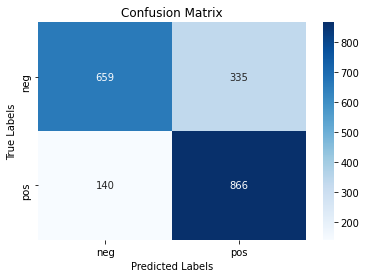

In [42]:
evaluate(model, dev_b_iter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Classification Report:
              precision    recall  f1-score   support

           1     0.9170    0.8339    0.8735      4980
           0     0.8488    0.9251    0.8853      5020

    accuracy                         0.8797     10000
   macro avg     0.8829    0.8795    0.8794     10000
weighted avg     0.8828    0.8797    0.8794     10000



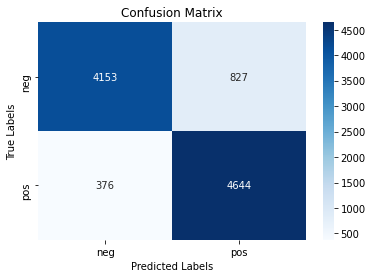

In [43]:
evaluate(model, dev_iter)

###4.2 Submission to Colab


After the implementation of models' architectures you are asked to participate in the [competition](https://competitions.codalab.org/competitions/30517) to solve **Sentiment Analysis for IMDb Movie Review** task using your implemented code. 


Upload obtained TSV file with your predictions (preds.tsv) in ``.zip`` for the best results on the dev set using BERT (or another Transformer based model)  to the **'Transformer' public leaderboard** of the competition: https://competitions.codalab.org/competitions/25623

Please, provide here in the notebook your user name in Codalab competition that we can recognize you in the leaderboard.


**YOUR USERNAME IN THE CODALAB LEADERBOARD:**

```

annakey

```

Upload the file to Codalab. Write below how it compared to scores of your submissions with simpler models in this assignment (LR, FFNN, RNN). 

```
Accuracy on practice:
BERT - 73.15967
LogReg - 72.578207
FFNN - 73.368996
RNN - 72.043261

Accuracy on evaluation:
BERT - 87.656
LogReg - 81.172
FFNN - 85.076
RNN - 82.28

As we can see BERT model gives the best results according to the accuracy on 
evaluation and the second best results according to the accuracy on practice.
```